<a href="https://colab.research.google.com/github/Pandu98-pkh/DeepLearning/blob/main/01.%20Week%201/Notebook%20Assigment/Classification%20Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
!pip install torch torchvision
!pip install tensorflow
!pip install numpy pandas matplotlib scikit-learn
!pip install category_encoders

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # untuk membagi data menjadi data latih dan data uji
from sklearn.preprocessing import LabelEncoder, MinMaxScaler # untuk mengubah label kelas menjadi angka
from sklearn.feature_selection import SelectKBest, f_classif
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import math

In [92]:
url = "https://raw.githubusercontent.com/Pandu98-pkh/DeepLearning/refs/heads/main/01.%20Week%201/Dataset/income.csv"

try:
  df = pd.read_csv(url).dropna()
except Exception as e:
  print(f"Error loading dataset: {e}")

In [93]:
df.sample(10) # menampilkan 10 sample data secara acak

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
21046,27,Private,60288,Masters,14,Never-married,Sales,Own-child,White,Female,0,0,40,United-States,<=50K
5530,34,State-gov,595000,Masters,14,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,United-States,>50K
44222,38,Private,175665,Some-college,10,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,<=50K.
30981,43,Private,233130,Bachelors,13,Divorced,Sales,Not-in-family,White,Male,0,0,40,United-States,>50K
21041,21,Private,100462,Assoc-voc,11,Never-married,Exec-managerial,Own-child,White,Female,2174,0,60,United-States,<=50K
7906,39,Self-emp-inc,283338,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,7298,0,40,United-States,>50K
13501,46,Private,423222,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,7688,0,40,United-States,>50K
12372,29,Private,199116,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,Puerto-Rico,<=50K
5985,58,Private,119558,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
19368,50,Self-emp-not-inc,163948,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,>50K


In [94]:
df.describe() # menampilkan statistik data

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,47621.000000,4.762100e+04,47621.000000,47621.000000,47621.000000,47621.000000
mean,38.640684,1.897271e+05,10.090821,1091.137649,87.853489,40.600050
std,13.558961,1.055695e+05,2.568320,7487.228336,404.010612,12.260345
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175840e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782820e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.377200e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47621 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             47621 non-null  int64 
 1   workclass       47621 non-null  object
 2   fnlwgt          47621 non-null  int64 
 3   education       47621 non-null  object
 4   education-num   47621 non-null  int64 
 5   marital-status  47621 non-null  object
 6   occupation      47621 non-null  object
 7   relationship    47621 non-null  object
 8   race            47621 non-null  object
 9   sex             47621 non-null  object
 10  capital-gain    47621 non-null  int64 
 11  capital-loss    47621 non-null  int64 
 12  hours-per-week  47621 non-null  int64 
 13  native-country  47621 non-null  object
 14  income          47621 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.8+ MB


In [96]:
# Menghapus spasi tambahan dari kolom kategori jika ada
db = df.apply(lambda x: x.str.strip(' .') if x.dtype == "object" else x)
# Mengubah target menjadi biner (0 = <=50K, 1 = >50K)
db['income'] = LabelEncoder().fit_transform(db['income'])
# Memisahkan fitur numerik dan kategorikal
num_cols = db.drop(columns=['income']).select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = db.select_dtypes(include=['object']).columns.tolist()

# Mengonversi variabel kategori menggunakan One-Hot Encoding
encoder = TargetEncoder()
db_encoded = encoder.fit_transform(db[cat_cols], db['income'])
db = db.drop(columns=cat_cols).join(db_encoded)

# Normalisasi fitur numerik
scaler = MinMaxScaler()
db[num_cols] = scaler.fit_transform(db[num_cols])

# Memisahkan fitur (X) dan target (y)
X = db.drop(columns=['income']).values
y = db['income'].values

print(X, y) # menampilkan data fitur dan label

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[[0.30136986 0.04413121 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.45205479 0.04805174 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.28767123 0.13758131 0.53333333 ... 0.25707351 0.30701068 0.24731133]
 ...
 [0.28767123 0.24537874 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.36986301 0.04844413 0.8        ... 0.27436075 0.30701068 0.24731133]
 [0.24657534 0.11491866 0.8        ... 0.25707351 0.30701068 0.24731133]] [0 0 0 ... 0 0 1]


In [97]:
# prompt: Mempersiapkan Rumus Evaluasi (Akurasi, Presisi, Recall, F1Squared, AUC, ROC)
# # Fungsinya untuk menghitung metrik evaluasi
# # Metrik evaluasi yang digunakan adalah akurasi, presisi, recall, F1-score, AUC, dan ROC

def evaluate_model(y_true, y_pred, y_prob):
    """
    Evaluates the model's performance using various metrics.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        y_prob: Predicted probabilities.

    Returns:
        A dictionary containing the evaluation metrics.
    """

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)


    # Calculate F1-squared
    f1_squared = f1**2

    evaluation_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'F1-Squared': f1_squared,
        'AUC': auc_score,
        'ROC_AUC': roc_auc
    }

    return evaluation_metrics


In [98]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Displays a confusion matrix to evaluate the model, showing percentages.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        model_name: Name of the model.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum() * 100 # Calculate percentages based on total

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", # Display percentages with 2 decimal places
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f'Confusion Matrix for {model_name} (Percentage)') # Update title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Iterasi setiap teks di dalam heatmap dan tambahkan tanda %
    for t in ax.texts:
        t.set_text(t.get_text() + " %")

    plt.show()

def plot_training_history(history, model_name):
    """
    Displays the training history of the model.

    Args:
        history: Training history object.
        model_name: Name of the model.
    """
    if 'accuracy' in history:
        plt.plot(history['val_accuracy'] if 'val_accuracy' in history else history['accuracy'])
        plt.plot(history['accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Validation', 'Training'], loc='upper left')
    plt.plot(history['val_loss'] if 'val_loss' in history else history['loss'])
    plt.plot(history['loss'])
    plt.yscale('log')
    plt.title('Model loss')
    plt.ylabel('Loss (log scale)')
    plt.xlabel('Epoch')
    if 'accuracy' in history:
        plt.legend(['Validation accuracy', 'Training accuracy', 'Validation loss', 'Training loss'], loc='upper left')
    elif 'val_loss' in history:
        plt.legend(['Validation loss', 'Training loss'], loc='upper left')
    else:
        plt.legend(['Loss'], loc='upper left')
    plt.show()


In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [100]:
# prompt: Mengonversi Dataset Menjadi Tipe Tensor PyTorch

# Mengonversi data latih dan data uji menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)  # Reshape y_train_tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)  # Reshape y_test_tensor

# Membuat TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Membuat DataLoader
batch_size = 32  # Contoh ukuran batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [101]:
# prompt: Menyusun Model Neural Network Sederhana pytorch

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model, define loss function, and optimizer
input_size = X_train.shape[1]
model = Net(input_size)

In [102]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [103]:
# Melatih model
num_epochs = 100 # Jumlah iterasi pelatihan
history = pd.DataFrame() # Menyimpan statistik pelatihan
for epoch in range(num_epochs):
    optimizer.zero_grad() # Mengatur gradien menjadi 0 sebelum melakukan backpropagation
    y_pred = model(X_train_tensor) # Memprediksi data latih
    loss = criterion(y_pred, y_train_tensor) # Menghitung loss
    loss.backward() # Backpropagation
    optimizer.step() # Update bobot
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss={loss.item()}')
    # Menyimpan statistik pelatihan untuk menampilkan plot
    history = pd.concat([history, pd.DataFrame({'epoch': [epoch], 'loss': [loss.item()]})], ignore_index=True)

Epoch 0, loss=0.7024028301239014
Epoch 10, loss=0.5727195739746094
Epoch 20, loss=0.5179915428161621
Epoch 30, loss=0.4351179003715515
Epoch 40, loss=0.3728612959384918
Epoch 50, loss=0.3514624834060669
Epoch 60, loss=0.34290438890457153
Epoch 70, loss=0.33571866154670715
Epoch 80, loss=0.33086466789245605
Epoch 90, loss=0.3262287974357605


In [104]:
# Evaluation
y_pred_list = []
y_prob_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_prob_list.extend(outputs.numpy())
        predicted = (outputs > 0.5).float() # Convert probabilities to binary predictions
        y_pred_list.extend(predicted.numpy())

y_pred_list = np.array(y_pred_list).reshape(-1)
y_prob_list = np.array(y_prob_list).reshape(-1)
#Evaluate the model
metrics = evaluate_model(y_test, y_pred_list, y_prob_list)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Accuracy: 0.8466
Precision: 0.7464
Recall: 0.5749
F1-Score: 0.6496
F1-Squared: 0.4219
AUC: 0.9049
ROC_AUC: 0.9049


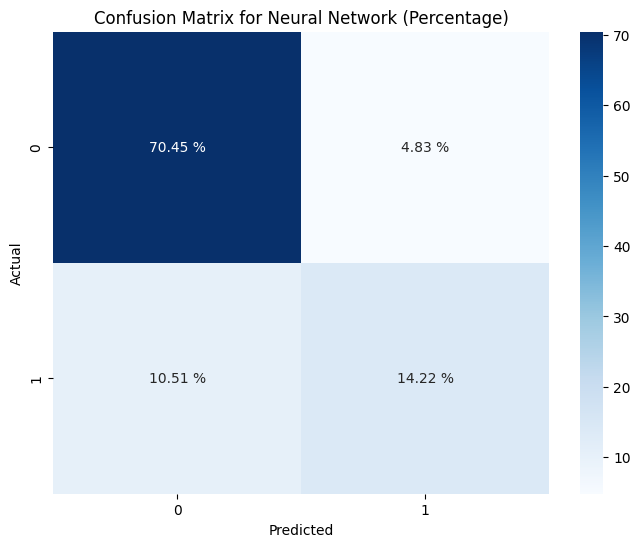

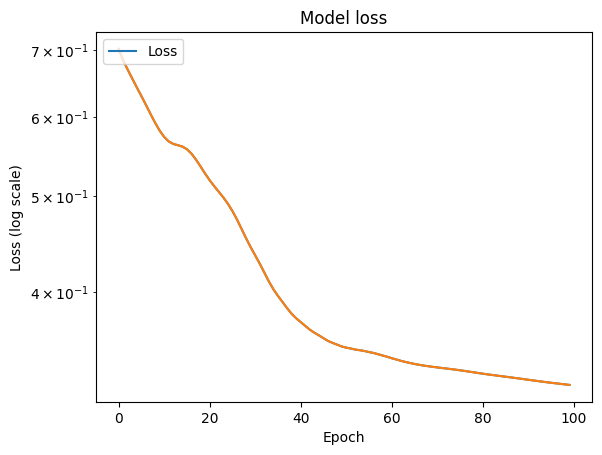

In [105]:
# prompt: Memvisualisasikan Prediksi dari model yang telah dilatih
#  plot_confusion_matrix(y_true, y_pred, model_name):
# def plot_training_history(history, model_name)

plot_confusion_matrix(y_test, y_pred_list, 'Neural Network')
# Assuming 'history' is available from the model training
plot_training_history(history, 'Neural Network')


In [106]:
# import untuk menambah layer pada model
import tensorflow as tf
from tensorflow import keras
# untuk membuat model neural network
from keras.models import Sequential
# untuk menambah layer pada model
from keras.layers import Dense, Input

In [107]:
# Menentukan hyperparameter model
input_dim = X_train.shape[1] # Jumlah fitur
hidden_dim = 64 # Jumlah neuron pada hidden layer
output_dim = 1 # Jumlah neuron pada output layer

# Inisialisasi model sequential
# Changed input_shape to match the actual input data shape
model_tf = Sequential([
    Dense(hidden_dim, activation='relu', input_shape=(input_dim,)), # Input layer
    Dense(hidden_dim, activation='relu') , # Layer input 128 neuron
    Dense(output_dim, activation='sigmoid')  # Layer output 1 neuron
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:
# Compile model (tentukan optimizer, loss function, dan metrics)
model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_tf.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,185 (20.25 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Train the TensorFlow/Keras model
history_tf = model_tf.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8079 - loss: 0.4161 - val_accuracy: 0.8421 - val_loss: 0.3337
Epoch 2/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8481 - loss: 0.3276 - val_accuracy: 0.8455 - val_loss: 0.3256
Epoch 3/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8477 - loss: 0.3268 - val_accuracy: 0.8503 - val_loss: 0.3203
Epoch 4/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8488 - loss: 0.3246 - val_accuracy: 0.8491 - val_loss: 0.3178
Epoch 5/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8509 - loss: 0.3214 - val_accuracy: 0.8503 - val_loss: 0.3181
Epoch 6/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8517 - loss: 0.3149 - val_accuracy: 0.8493 - val_loss: 0.3215
Epoch 7/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8554 - loss: 0.3134 - val_accuracy: 0.8506 - val_loss: 0.3178
Epoch 8/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8521 - loss: 0.3142

In [110]:
# Evaluate the model
y_pred_prob = model_tf.predict(X_test)  # Use model_tf instead of model
y_pred = (y_pred_prob > 0.2).astype(int)  # Convert probabilities to binary predictions

metrics = evaluate_model(y_test, y_pred, y_pred_prob)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8002
Precision: 0.5605
Recall: 0.8892
F1-Score: 0.6876
F1-Squared: 0.4728
AUC: 0.9141
ROC_AUC: 0.9141


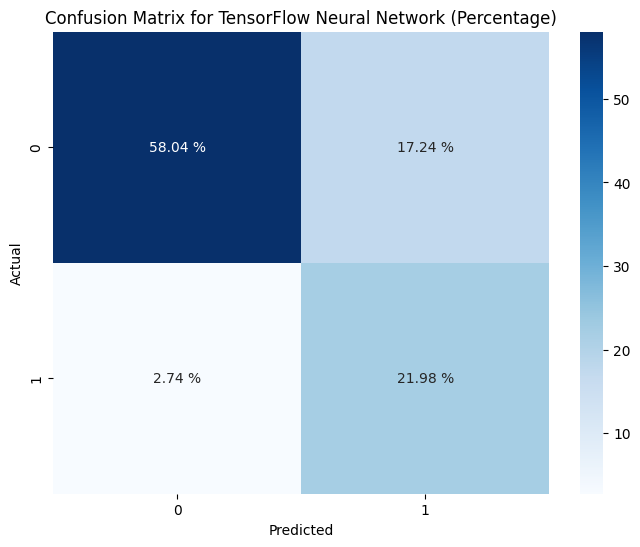

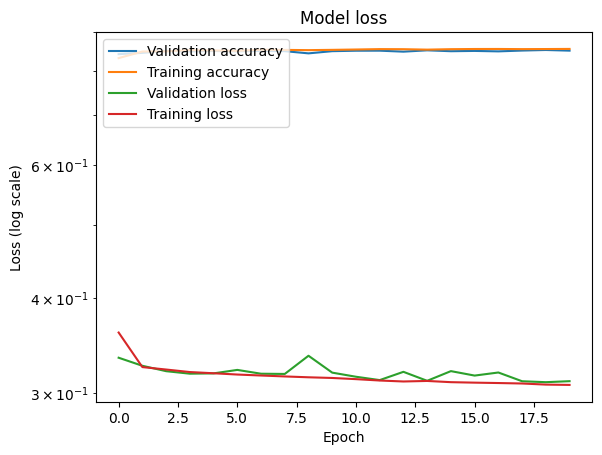

In [111]:
plot_confusion_matrix(y_test, y_pred, 'TensorFlow Neural Network')
plot_training_history(history_tf.history, 'TensorFlow Neural Network') # Changed history to history_tf.history